#**Physics-based loss and machine learing approach in application to fluids flow modelling: 2D flow domains**

The program recieves an image of the flow domain and the flow rate value, then calculate velocity distribution. The main idea is power loss minimization. The main unknown function is the stream function $\psi = \psi(x_1, x_2)$ that determines the velocity field $\textbf{V} = [[v_1, v_2]]$, where $v_1 = \frac{\partial \psi}{\partial x_2}$, $v_2 = - \frac{\partial \psi}{\partial x_1}$.



#Libraries

## Install libraries

In [19]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

C:\Users\IMS\Anaconda3\envs\Ivan\lib\site-packages\fastbook\__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


## Import libraries

In [20]:
from fastai.vision.all import *
import cv2
import torch
#from google.colab.patches import cv2_imshow
#from collections import OrderedDict

#Functions

## Additional functions

Numerical derivative

In [61]:
def num_diff(f, dx1, dx2):
  '''function to find partial derivatives of a two variables function:
  i - index along x1
  j - index along x2
  for internal points - central differences e.q. df_dx = (f_{i+1}-f_{i-1})/(2*dx)
  for boundaries - left and right finite differences e.q. df_dx = (f_{i+1}-f_{i})/dx or df_dx = (f_{i}-f_{i-1})/dx
  '''
  n1, n2 = f.shape
  df_dx1 = 0
  df_dx2 = 0
  df_dx1, df_dx2 = torch.zeros(n1,n2), torch.zeros(n1,n2)
  if torch.cuda.is_available():
    df_dx1 = df_dx1.to('cuda')
    df_dx2 = df_dx2.to('cuda')
  # x1 derivative:
  df_dx1[:, 1:n2-1] = (f[:,2:] - f[:,:-2])/(2*dx1)
  df_dx1[:, 0] = (-f[:,2] + 4*f[:,1] - 3*f[:,0])/(2*dx1)
  df_dx1[:,n2-1] = (3*f[:,n2-1] - 4*f[:,n2-2] + f[:,n2-3])/dx1
  # x2 derivative:
  df_dx2[1:n1-1,:] = (f[2:,:] - f[:-2,:])/(2*dx2)
  df_dx2[0,:] = (-f[2,:] + 4*f[1,:] - 3*f[0,:])/(2*dx2)
  df_dx2[n1-1,:] = (3*f[n1-1,:] - 4*f[n1-2,:] + f[n1-3,:])/(2*dx2)

  return df_dx1, df_dx2

Numerical integrals: single and double can be implemented by torch.trapezoid function https://pytorch.org/docs/stable/generated/torch.trapezoid.html#torch.trapezoid


Color filter 

In [12]:
def colorFilter(img, color):
  white = (255,255,255,255)
  black = (0,0,0,255)
  width,heigth = img.size
  for i in range(width):
    for j in range(heigth):
      if img.getpixel((i,j)) == color:
        img.putpixel((i,j),black)
      else:
        #print(img.getpixel((i,j)))
        img.putpixel((i,j),white)
  return (img)

##Major functions

Distributions: the velocity components [[$v_1$, $v_2$]], the strain rate tensor components [[$\xi_{ij}$]], $\xi_{ij}=\xi_{ji}$ . And the shear rate intensity Η. 

In [13]:
def velocityDistr(psi,dx1n,dx2n,lim1,lim2):

  n = psi.shape
  v1 = 0
  v2 = 0
  dpsidx1 = 0
  dpsidx2 = 0
  dpsidx1, dpsidx2 = num_diff(psi, dx1n, dx2n)
  v1 = dpsidx2/lim2[1]
  v2 = - dpsidx1/lim1[1]

  return v1,v2

In [14]:
def TksiDistr(v1,v2,dx1n,dx2n,lim1,lim2):

  n = v1.shape
  xi11 = 0
  xi12 = 0
  xi22 = 0
  dv1dx1 = 0
  dv1dx2 =0
  dv2dx1 = 0
  dv2dx2 = 0

  dv1dx1, dv1dx2 = num_diff(v1, dx1n, dx2n)
  dv2dx1, dv2dx2 = num_diff(v2, dx1n, dx2n)

  xi11 = dv1dx1/lim1[1]
  xi12 = 0.5*(dv1dx2/lim2[1] + dv2dx1/lim1[1])
  xi22 = dv2dx2/lim2[1]
  EtaEta = (2*(xi11*xi11 + 2*xi12*xi12 + xi22*xi22))

  return xi11,xi12,xi22,EtaEta

# Initialization

##Image of the flow domain

Path

In [15]:
 path =  Path('/content/gdrive/MyDrive/study/Publications/2022/IEEE-CEC-2022/physical-loss')
 #path =  Path('/home/physical-loss')
 imgPath = path/'ToyDataset'
 imgList = imgPath.ls()
 imgPath.ls()

NameError: name 'Path' is not defined

##Simulation

In [103]:
#Training
noOfFeatures = 4
noOfEpoch = 10000
learnRate = 0.01

##Geometry
The domain of size *'L x L'*  with flow channel is represented as an image of size *'imgSize x imgSize'*. S1 is the upper wall with black label [0 0 0]. S2 and S4 are outlet and inlet surfaces, respectivelly. S3 is the lower wall with blue label [0 0 255]. 

In [17]:
L = 0.1 # L x L flow domain
imgSize = 512 # imgSize x imgSize pixels image
imgNo = 2
upperWallColor =  (0, 0, 0,255)
lowerWallColor =  (0, 0, 255,255)
#Normalized coordinates
x1n = torch.linspace(0,1,imgSize)
x2n = torch.linspace(0,1,imgSize)
dx1n = x1n[1] - x1n[0]
dx2n = x2n[1] - x2n[0]
lim1 = [0, L]
lim2 = [0, L]
#Visualisation
figSize = 3


Check diff

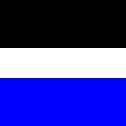

In [26]:
domainMask = Image.open('Physics-based-loss-and-machine-learning-approach-in-application-to-non-Newtonian-fluids-flow-modelin-main/mlIzur4sNm0.jpg')
domainMask 

Create masks for the walls and resize image

In [29]:

upperWallMask = colorFilter(domainMask, upperWallColor)
upperWallMask = upperWallMask.resize((imgSize,imgSize),resample=4)
#upperWallMask

In [30]:
domainMask = Image.open(imgList[imgNo])
lowerWallMask = colorFilter(domainMask, lowerWallColor)
lowerWallMask = lowerWallMask.resize((imgSize,imgSize),resample=4)
#lowerWallMask

##Kinematic properties
The velocity is equal to zero on all the surfaces. The flow rate is known.

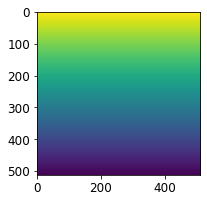

In [31]:
Q = 1 #flow rate through the inlet (outlet) boundary, m^3/s
psim = 0 # lower wall
psip = Q # upper wall
psi00 = torch.linspace(Q*4,0,imgSize, dtype=torch.float32)*torch.ones(imgSize,imgSize)
psi0 = torch.t(psi00)-1.5*Q
fig = plt.figure(figsize=(figSize, figSize))
plt.imshow(psi0)
#psi0[:,1]

In [32]:
psi00.dtype

torch.float32

Text(0.5, 1.0, 'psi function with mask')

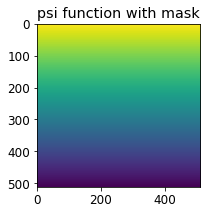

In [33]:
wallsMask = (tensor(upperWallMask)[:,:,1]*tensor(lowerWallMask)[:,:,1])
inverseUpperWallMask = (tensor(upperWallMask)[:,:,1]/(-255)+1)
psi0Masked = (psi0*wallsMask) + (inverseUpperWallMask*Q)
fig = plt.figure(figsize=(figSize, figSize))
plt.imshow(psi0Masked)
plt.title('psi function with mask')

In [34]:
#velocityMask = torch.ones(imgSize,imgSize)
#velocityMask[:,0:3] = 0
#velocityMask[:,-3:] = 0
#fig = plt.figure(figsize=(figSize, figSize))
#plt.plot(velocityMask[1,:])
#velocityMask[1,:]

In [35]:
#h=(126-92)*L/126
#vm = (velocityMask*-1 + 1)*Q/L
#Qcalc = torch.trapezoid(vm.t())*dx2n*L
#plt.plot(Qcalc)

In [36]:
#v1Mask = vm*wallsMask
#fig = plt.figure(figsize=(figSize*4, figSize*2))
#plt.imshow(v1Mask )
#plt.title('v1 mask')
#v1Mask[300,:]

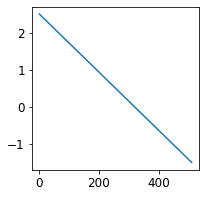

In [37]:
fig = plt.figure(figsize=(figSize, figSize))
plt.plot(psi0Masked[:,200])

Velocity distribution

Text(0.5, 1.0, 'v2')

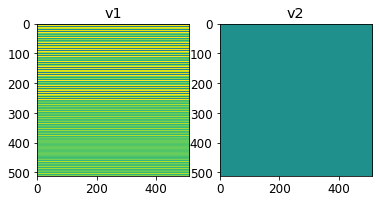

In [38]:
v1, v2 = velocityDistr(psi0Masked,dx1n,dx2n,lim1,lim2)
#v1Masked = (v1*velocityMask) + v1Mask
#v2Masked = (v2*velocityMask)
#v2Masked = torch.zeros(imgSize,imgSize)
fig = plt.figure(figsize=(figSize*2, figSize))
plt.subplot(1,2,1)
plt.imshow(v1)
plt.title('v1')
plt.subplot(1,2,2)
plt.imshow(v2)
plt.title('v2')

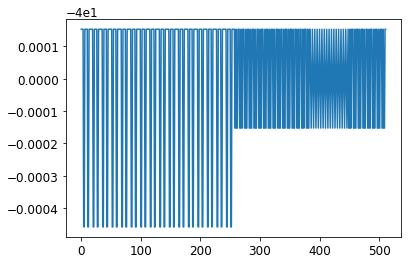

In [39]:
plt.plot(v1[:,1])

In [40]:
Qch = torch.trapezoid(v1.t())*dx1n*L
plt.plot(Qch)

AttributeError: module 'torch' has no attribute 'trapezoid'

##Dynamic properties
The fluid is Newtonian.

In [41]:
mu = 1e-3 # koefficient of dynamic viscosity (viscosity), Pa*s

##Check assimptotic solution
Newtonian fluid flows between parallel plates LxL

In [44]:
#h=(126-92)*L/126
pressureDrop = Q*3*mu*L/(2*L*L*L)
externalPower = pressureDrop*Q
v1ex = pressureDrop/(2*mu*L)*(1-x2n*x2n)*L*L
psiex = pressureDrop/(2*mu*L)*(1-x2n*x2n/3)*L*L*L*x2n
print('h =',L,'pressure drop =',pressureDrop,'external power =',externalPower)
psiex2d = psiex*torch.ones(imgSize,imgSize)
psiex2dt = psiex2d.t()
plt.imshow(psiex2dt)

TypeError: unsupported operand type(s) for *: 'float' and '_L_Meta'

In [43]:
plt.plot(psiex2dt[:,1])

NameError: name 'psiex2dt' is not defined

In [ ]:
v1ch, v2ch = velocityDistr(psiex2dt,dx1n,dx2n,lim1,lim2)
fig = plt.figure(figsize=(figSize*2, figSize))
plt.subplot(1,2,1)
plt.imshow(v1ch)
plt.title('v1')
plt.subplot(1,2,2)
plt.imshow(v2ch)
plt.title('v2')

In [ ]:
fig = plt.figure(figsize=(figSize*2, figSize))
plt.subplot(1,2,1)
plt.plot(v1ch[:,1])
plt.title('v1')
plt.subplot(1,2,2)
plt.plot(x1n,-v1ch[:,1],'-r',x1n,v1ex,'--b')
plt.title('v2')

In [ ]:
v1ch.max(),v1ch.min(),v2ch.max(),v2ch.min()

flow rate

In [ ]:
Qcalc = torch.trapezoid(v1.t())*dx1n*L
plt.plot(Qcalc)

In [ ]:
fig = plt.figure(figsize=(figSize*2, figSize))
plt.subplot(1,2,1)
plt.plot(v1ex)
plt.subplot(1,2,2)
plt.plot(psiex)

#Training

##Create model
Unet architecture [2] is used

In [124]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=noOfFeatures):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )


        
model = UNet(in_channels=1, out_channels=1, init_features=32)

In [136]:
# Сохранение и загрузка всей сети

torch.save(model.state_dict(), 'model.pth')
model.load_state_dict(torch.load('model.pth'))

In [140]:
# Сохранение и загрузка всей сети

torch.save(model.encoder1.state_dict(), 'encoder1.pth')
model.encoder1.load_state_dict(torch.load('encoder1.pth'))

In [125]:
#model

## Optimizer

In [126]:
# optimizer = torch.optim.Adam(model.parameters(), lr=learnRate)
optimizer = torch.optim.SGD(model.parameters(), lr=learnRate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.1)

##Input image

In [127]:
psi0Masked.dtype

torch.float32

In [128]:
#x = torch.randn((1, 1, 512, 512))
x = torch.ones((1, 1, imgSize, imgSize))*psi0Masked
#fig = plt.figure(figsize=(3, 3))
#plt.imshow(x[0,0,:,:])
x.dtype, x.shape

(torch.float32, torch.Size([1, 1, 512, 512]))

In [129]:
#model(x)

In [130]:
s = dx1n*dx2n*lim1[1]*lim2[1]
s

tensor(3.8296e-08, device='cuda:0')

In [131]:
history = []

# Перемещение на GPU
if torch.cuda.is_available():
    x = x.to('cuda')
    model = model.to('cuda')
    wallsMask = wallsMask.to('cuda')
    inverseUpperWallMask = inverseUpperWallMask.to('cuda')
    dx1n = dx1n.to('cuda')
    dx2n = dx2n.to('cuda')
    s = s.to('cuda')
    EtaEta = EtaEta.to('cuda')

for epoch in range(noOfEpoch):

    psi = model(x)
    psiMasked = (psi[0,0,:,:]*wallsMask) + (inverseUpperWallMask*Q)
#     print(psi[0,0,:,:].shape)
    v1,v2 = velocityDistr(psiMasked,dx1n,dx2n,lim1,lim2)

    #v1Masked = (v1*velocityMask) + v1Mask
    #v2Masked = (v2*velocityMask)
    #v2Masked = torch.zeros(imgSize,imgSize)

    xi11,xi12,xi22,EtaEta = TksiDistr(v1,v2,dx1n,dx2n,lim1,lim2)
    #xi11,xi12,xi22,EtaEta = TksiDistr(v1Masked,v2Masked,dx1n,dx2n,lim1,lim2)
    
    #int1EtaEta = torch.trapezoid(EtaEta)
    #int2EtaEta = torch.trapezoid(int1EtaEta)
    #out = 0.5*mu*s*int2EtaEta #doublelIntegral(0.5*mu*EtaEta,lim1,lim2) #loss
    out = 0.5*mu*s*EtaEta.sum()
    history.append(out.item())
    out.backward()
    optimizer.step()
    lr_scheduler.step()
    print('#iter',epoch,'loss', history[-1])
    if out < 1e-6:
        break

#iter 0 loss 42512980.0
#iter 1 loss 1831927.0
#iter 2 loss 373899168.0
#iter 3 loss 373899168.0
#iter 4 loss 373899168.0
#iter 5 loss 373899168.0
#iter 6 loss 373899168.0
#iter 7 loss 373899168.0
#iter 8 loss 373899168.0
#iter 9 loss 373899168.0
#iter 10 loss 373899168.0
#iter 11 loss 373899168.0
#iter 12 loss 373899168.0
#iter 13 loss 373899168.0
#iter 14 loss 373899168.0
#iter 15 loss 373899168.0
#iter 16 loss 0.0


In [112]:
out

tensor(0., device='cuda:0', grad_fn=<MulBackward0>)

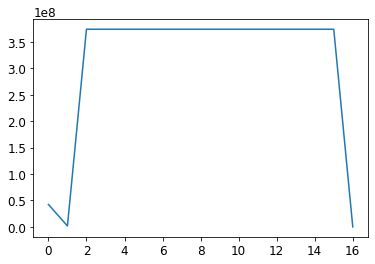

In [132]:
plt.plot(history)

Visualisation

In [133]:
psi[0,0,:,:].shape

torch.Size([512, 512])

C:\Users\IMS\AppData\Local\Temp/ipykernel_44572/2335847364.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psicheck = torch.tensor(psi[0,0,:,:],requires_grad=False)


Text(0.5, 1.0, 'psi function with mask')

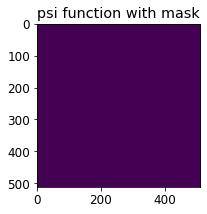

In [134]:
psicheck = torch.tensor(psi[0,0,:,:],requires_grad=False)
psiMasked = (psicheck*wallsMask) + (inverseUpperWallMask*Q)
fig = plt.figure(figsize=(figSize, figSize))
plt.imshow(psiMasked.to('cpu'))
plt.title('psi function with mask')

Text(0.5, 1.0, 'psi function slice')

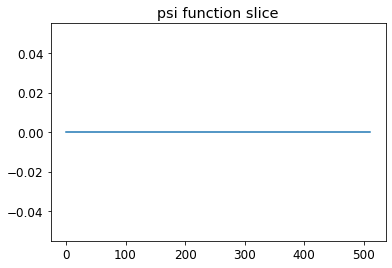

In [118]:
plt.plot(psiMasked[:,250].to('cpu'))
plt.title('psi function slice')

Text(0.5, 1.0, 'v2')

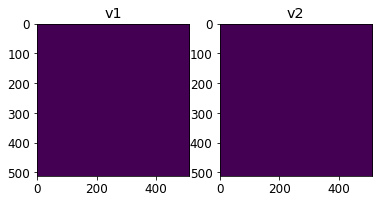

In [120]:
v1, v2 = velocityDistr(psiMasked,dx1n,dx2n,lim1,lim2)
fig = plt.figure(figsize=(figSize*2, figSize))
plt.subplot(1,2,1)
plt.imshow(v1.to('cpu'))
plt.title('v1')
plt.subplot(1,2,2)
plt.imshow(v2.to('cpu'))
plt.title('v2')

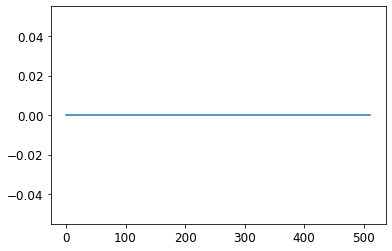

In [121]:
plt.plot(v1[:,250].to('cpu'))

In [122]:
Qcalc = torch.trapezoid(v1.t())*dx2n*L
plt.plot(Qcalc)

AttributeError: module 'torch' has no attribute 'trapezoid'

In [ ]:
Qcalc.mean()
h

#Links

[1]. https://github.com/Mechanics-Mechatronics-and-Robotics/Mathematical_modelling/blob/main/Practice_1_by_IStebakov.ipynb

[2]. https://github.com/mateuszbuda/brain-segmentation-pytorch